# Handwritten Digit Classification:  
- use Perceptron() model to recognize given digit images.
- Since a single perceptron could only be used for binary classification, we consider only two classes in the first half. Eventually we extend it to multi-class setting.
- Suppose we want to recognize whether the given image is of digit zero or not (digits other than zero). Then the problem could be cast as a binary classification problem.
- We will use the standard benchmark dataset called **MNIST**.

In [1]:
# Common imports
import numpy as np
import os
import io
import warnings

# sklearn specific imports
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import MinMaxScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import Perceptron
from sklearn.metrics import hinge_loss
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, precision_recall_curve
from sklearn.metrics import precision_score, recall_score, classification_report
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate, cross_val_predict, GridSearchCV
from pprint import pprint

# To plot pretty figures
import matplotlib.pyplot as plt
import seaborn as sns

## Data Loading and Splitting

In [2]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
# it returns Data and label as a pandas dataframe

The data matrix X and the respective label vector y need to be converted to the numpy array by calling a `to_numpy` method.

In [3]:
X = X.to_numpy()
y = y.to_numpy()

- Let's get some information like number of features, number of classes about the dataset.
- Observe that the labels are of string data type not integers.

In [4]:
target_names = np.unique(y)
print('Number of samples: {0}, type:{1}'.format(X.shape[0], X.dtype))
print('Number of features: {0}'.format(X.shape[1]))
print('Minimum:{0}, Maximum:{1}'.format(np.min(X), np.max(X)))
print('Number of classes: {0}, type:{1}'.format(len(target_names), y.dtype))
print('Labels: {0}'.format(target_names))

Number of samples: 70000, type:float64
Number of features: 784
Minimum:0.0, Maximum:255.0
Number of classes: 10, type:object
Labels: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


In [5]:
# feature Normalization
X = MinMaxScaler().fit_transform(X)
print('Minimum:{0}, Maximum:{1}'.format(np.min(X), np.max(X)))

Minimum:0.0, Maximum:1.0


## Data Visualization
Let us pick a few images (already shuffled in the dataset) and display them with their respective labels. The images are stacked as a row vector of size $1 \times 784$ and therefore must be reshaped to the matrix of size $28 \times 28$ to display them properly.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


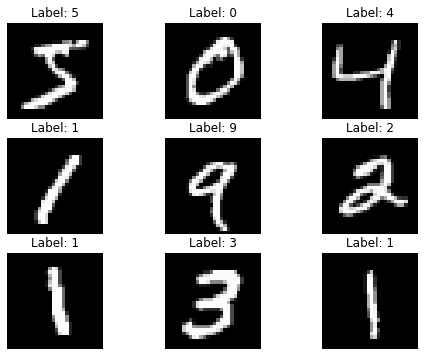

In [6]:
num_images = 9 # choose a square number
factor = np.int(np.sqrt(num_images))
fig, ax = plt.subplots(nrows=factor, ncols=factor, figsize=(8,6))
idx_offset = 0 # take "num_images" starting from the index "idx_offset"
for i in range(factor):
    index = idx_offset + i*factor
    for j in range(factor):
        ax[i,j].imshow(X[index+j].reshape(28,28), cmap='gray')
        ax[i,j].set_title('Label: {0}'.format(str(y[index+j])))
        ax[i,j].set_axis_off()

## Data Splitting
- Split into train and test set in ratio: 60000/10000
- Since the samples are already shuffled, we can skip `train_test_split()`.

In [7]:
x_train, x_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Before proceeding, we need to check whether the dataset is balanced or imbalanced.

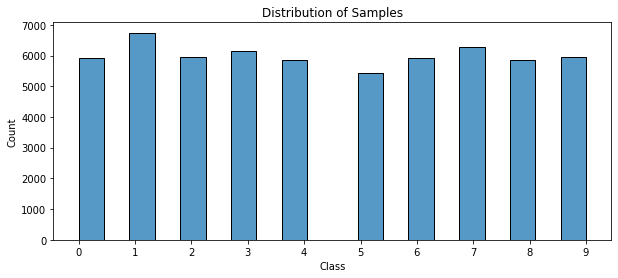

In [8]:
plt.figure(figsize=(10,4))
sns.histplot(data=np.int8(y_train),binwidth=0.45, bins=11)
plt.xticks(ticks=[0,1,2,3,4,5,6,7,8,9], labels=[0,1,2,3,4,5,6,7,8,9])
plt.xlabel('Class')
plt.title('Distribution of Samples')
plt.show()

# Binary Classification: 0-Detector
## Modifying labels
- Since the original label vector contains 10 classes, we need to modify the number of classes to 2
- Therefore, the label 0 will be changed to 1 and all other labels (1-9) will be changed to -1.
- We name the label vector as y_train_0 and y_test_0.

In [9]:
# initialize new vaiable names with all -1
y_train_0 = -1*np.ones((len(y_train)))
y_test_0 = -1*np.ones((len(y_test)))

# find indices of digit 0 image
indx_0 = np.where(y_train == '0') # since the original labels are of type str not int
# use those indices to modify y_train_0 & y_test_0
y_train_0[indx_0] = 1
indx_0 = np.where(y_test == '0')
y_test_0[indx_0] = 1

# Baseline Models

In [10]:
num_pos = len(np.where(y_train_0 == 1)[0])
num_neg = len(np.where(y_train_0 == -1)[0])
print(num_pos, num_neg)

5923 54077


In [11]:
base_clf = DummyClassifier(strategy='most_frequent')
# the model "always outputs" the class which has highest number of samples.

In [12]:
base_clf.fit(x_train, y_train_0)
print('Training accuracy: {0:.2f}'.format(base_clf.score(x_train, y_train_0)))
print('Testing accuracy: {0:.2f}'.format(base_clf.score(x_test, y_test_0)))

Training accuracy: 0.90
Testing accuracy: 0.90


- Now the reason is obvious. The model would have predicted 54077 samples correctly just by outputing -1 for all the input samples. Therefore the accuracy will be $\frac{54077}{60000} = 90.12\%$.
- This is the reason why "accuracy" alone is not always a good measure!

# Perceptron model

## Instantiation

In [13]:
bin_clf = Perceptron(max_iter=100, random_state=1729)

## Training and Prediction
- Call the `fit` method to train the model
- It would be nice to plot the iteration vs loss curve for the training. However sklearn does not have a direct function to plot it.
- Nevertheless, we can workaround this using `partial_fit` method. (demonstrated at the end)

In [14]:
bin_clf.fit(x_train, y_train_0)
print('Dimension of Weights w: {0}'.format(bin_clf.coef_.shape))
print('Bias: {0}'.format(bin_clf.intercept_))
print('The loss function: {0}'.format(bin_clf.loss_function_))

Dimension of Weights w: (1, 784)
Bias: [-108.]
The loss function: <sklearn.linear_model._sgd_fast.Hinge object at 0x7fa909550f30>


Let's make predictions on the train set and then calculate the training accuracy.

In [15]:
y_hat_train_0 = bin_clf.predict(x_train)
print('Training accuracy: ', bin_clf.score(x_train, y_train_0))
print('Test accuracy: ', bin_clf.score(x_test, y_test_0))

Training accuracy:  0.99095
Test accuracy:  0.989


## Displaying predictions


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


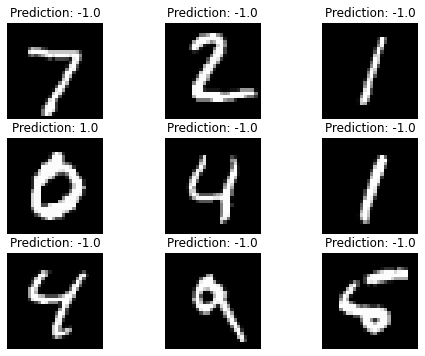

In [16]:
y_hat_test_0 = bin_clf.predict(x_test)
num_images = 9 # choose a square number
factor = np.int(np.sqrt(num_images))
fig, ax = plt.subplots(nrows=factor, ncols=factor, figsize=(8,6))
idx_offset = 0 # take "num_images" starting from the index "idx_offset"
for i in range(factor):
    index = idx_offset + i*factor
    for j in range(factor):
        ax[i,j].imshow(x_test[index+j].reshape(28,28), cmap='gray')
        ax[i,j].set_title('Prediction: {0}'.format(str(y_hat_test_0[index+j])))
        ax[i,j].set_axis_off()

- Display images of positive class from testset along with their predictions.

In [17]:
indx_0 = np.where(y_test_0 == 1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


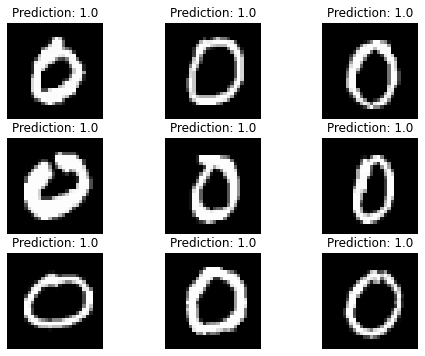

In [18]:
zeroImgs = x_test[indx_0[0]]
zeroLabls = y_hat_test_0[indx_0[0]]
num_images = 9 # choose a square number
factor = np.int(np.sqrt(num_images))
fig, ax = plt.subplots(nrows=factor, ncols=factor, figsize=(8,6))
idx_offset = 0 # take "num_images" starting from the index "idx_offset"
for i in range(factor):
    index = idx_offset + i*factor
    for j in range(factor):
        ax[i,j].imshow(zeroImgs[index+j].reshape(28,28), cmap='gray')
        ax[i,j].set_title('Prediction: {0}'.format(str(zeroLabls[index+j])))
        ax[i,j].set_axis_off()

## Evaluation metrics

In [19]:
num_misclassified = np.count_nonzero(zeroLabls==-1)
num_correctpred = len(zeroLabls)-num_misclassified
accuracy = num_correctpred/len(zeroLabls)
print(accuracy)

0.9193877551020408


Since accuracy is not a good evaluation metric in case of imbalanced data.
### Confusion Matrix

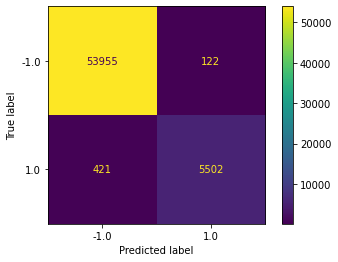

In [20]:
y_hat_train_0 = bin_clf.predict(x_train)
cm_display = ConfusionMatrixDisplay.from_predictions(y_train_0, y_hat_train_0, values_format='.5g')
plt.show()

### Precision and Recall

In [21]:
cf_matrix = cm_display.confusion_matrix
tn = cf_matrix[0,0]
fn = cf_matrix[1,0]
fp = cf_matrix[0,1]
tp = cf_matrix[1,1]

In [22]:
precision = tp/(tp+fp)
print('Precision: ', precision)
recall = tp/(tp+fn)
print('Recall: ', recall)
accuracy = (tn+tp)/(tn+tp+fn+fp)
print('Accuracy: ', accuracy)

Precision:  0.9783072546230441
Recall:  0.9289211548201924
Accuracy:  0.99095


Despite the precision is close to 0.98, we still want to increase the precision.

## Cross Validation

In [23]:
bin_clf = Perceptron(max_iter=100, random_state=1729)
scores = cross_validate(bin_clf, x_train, y_train_0, cv=5,
                        scoring=['precision', 'recall', 'f1'],
                        return_estimator=True)
pprint(scores)

{'estimator': [Perceptron(max_iter=100, random_state=1729),
               Perceptron(max_iter=100, random_state=1729),
               Perceptron(max_iter=100, random_state=1729),
               Perceptron(max_iter=100, random_state=1729),
               Perceptron(max_iter=100, random_state=1729)],
 'fit_time': array([0.74776649, 1.50749898, 1.07574725, 0.94781208, 1.22139788]),
 'score_time': array([0.02995753, 0.02965689, 0.02848744, 0.02866173, 0.0293119 ]),
 'test_f1': array([0.95238095, 0.91666667, 0.94915254, 0.94117647, 0.95091763]),
 'test_precision': array([0.95890411, 0.98828125, 0.95319149, 0.95090439, 0.96200345]),
 'test_recall': array([0.94594595, 0.85472973, 0.94514768, 0.93164557, 0.94008439])}


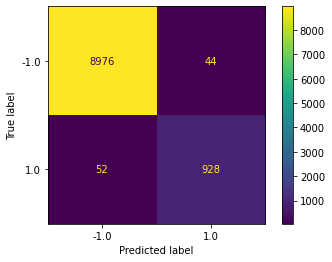

In [24]:
bin_clf = scores['estimator'][0]
# since the first estimator has the best f1 score
y_hat_test_0 = bin_clf.predict(x_test)
cm_display = ConfusionMatrixDisplay.from_predictions(y_test_0, y_hat_test_0, values_format='.5g')

In [25]:
print('Precision %.2f'%precision_score(y_test_0, y_hat_test_0))
print('Recall %.2f'%recall_score(y_test_0, y_hat_test_0))

Precision 0.95
Recall 0.95


In [26]:
print(classification_report(y_train_0,y_hat_train_0))

              precision    recall  f1-score   support

        -1.0       0.99      1.00      0.99     54077
         1.0       0.98      0.93      0.95      5923

    accuracy                           0.99     60000
   macro avg       0.99      0.96      0.97     60000
weighted avg       0.99      0.99      0.99     60000



> - Precision/Recall trade off
> - PR curve
> - ROC curve

# Multiclass Perceptron
1. Use `LabelBinarizer` to apply **One-hot encoding** on the label vector. The label vector will be converted to label matrix.
2. After obtaining one-hot representation of the labels we exactly the same code that we used for the binary case and perform multiclass classification with Perceptron.